In [1]:
import networkx as nx
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

from API import K
import requests
import json
import googlemaps
from dms2dec.dms_convert import dms2dec
import geopy.distance

## Import network and IVS data

In [2]:
# import network
G = pickle.load(open('data/network_digital_twin_v0.3.pickle', 'rb'))

# import cleaned and restructured IVS data
df_ivs = pickle.load( open("data/df_trips_per_path.p", "rb" ) )

df_h = pd.read_csv('data/cleaned_harbours.csv')
# extract position for drawing purposes
pos_dict = {}
for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'],G.nodes[node]['Y'])

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

# add degree to dataframes
df_links['degree_source'] = df_links.source.apply(lambda x: G.degree[x])
df_links['degree_target'] = df_links.source.apply(lambda x: G.degree[x])
df_nodes['degree'] = G.degree
df_nodes['degree'] = df_nodes.degree.apply(lambda x: x[1])

In [3]:
df_ivs.replace(0,np.nan, inplace=True)
# for now only consider 100 most frequented origin destination pairs, may reconsider later
df_ivs = df_ivs.head(100)
# check dataframe
df_ivs

,origin,destination,trip_count,M12,M8,M9,BIIa-1,BII-6b,M10,BII-6l,...,C4,C2l,M0,B04,BII-2L,B02,C1b,C2b,B01,C1l
0,NLRTM,NLAMS,9943,2076.0,3510.0,1316.0,102.0,NaN,427.0,NaN,...,5.0,7.0,11.0,5.0,39.0,4.0,NaN,NaN,NaN,NaN
1,NLRTM,NLMOE,2686,70.0,1584.0,144.0,2.0,NaN,56.0,NaN,...,2.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,NLRTM,NLVLI,2153,190.0,658.0,414.0,10.0,NaN,140.0,NaN,...,NaN,2.0,2.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN
3,NLAMS,NLAER,2119,6.0,132.0,NaN,2.0,NaN,7.0,NaN,...,NaN,1.0,5.0,37.0,NaN,3.0,NaN,1.0,1.0,NaN
4,NLRTM,NLRTM,1794,363.0,715.0,92.0,15.0,NaN,164.0,1.0,...,4.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NLNIJ,NLAMS,352,4.0,145.0,10.0,23.0,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
96,NLFAR,NLRTM,342,NaN,309.0,10.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
97,NLRTM,NLVSN,342,NaN,206.0,126.0,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,NLPER,NLAMS,328,9.0,127.0,32.0,NaN,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
for i in df_ivs.index:
    print(df_ivs.iloc[i,:].notnull().sum()-3)
    # print(df_ivs.iloc[i,:].isnull())

27
20
22
22
21
13
8
21
17
16
22
18
9
20
4
22
16
9
22
21
10
14
21
13
11
10
24
18
19
7
9
20
14
6
13
15
5
23
17
8
8
7
23
14
13
18
21
21
13
13
8
6
19
11
12
15
15
13
18
9
11
5
10
6
16
16
11
3
6
6
13
14
10
10
8
14
11
9
8
4
10
13
17
17
7
7
21
4
11
10
17
12
3
15
5
20
11
7
10
9


## Step 1: Select relevant harbours and determine decimal degrees coordinates for all habours

In [5]:
# # get unique harbours from IVS dataframe
# h_list = list(set(list(df_ivs.origin.unique())) | set(list(df_ivs.destination.unique())))
#
# # get unique city codes (e.g. remove NL prefix)
# h_list = [re.sub("NL", "", i) for i in h_list]

# subset harbour data for these harbours and reset index
# df_h = df_h.loc[(df_h.city_abbr.isin(h_list)) & (df_h.country == 'NL')]
# df_h.reset_index(inplace=True, drop=True)

In [6]:
# fix dtypes
# for i in df_h.columns:
#     if df_h.dtypes[i] == 'O':
#         df_h[i] = df_h[i].astype('|S80')
#         df_h[i] = df_h[i].apply(lambda x: x.decode('utf-8'))
# the coordinates are inaccurate and quite a lot of data is missing. This must be fixed first before we continue.

In [7]:
# #convert latitude and longitude to decimal degrees for harbours with this entry
# df_h['lat'] = 0
# df_h['lon'] = 0
# for key, coords in enumerate(df_h.coords):
#     lat_lon=[]
#     if coords!='nan':
#         for j in range(2):
#             if j == 0:
#                 part_a = coords.split()[j][:2]
#                 part_b = coords.split()[j][-3:-1]
#                 cor = (str(part_a)+"°"+str(part_b)+''''0"N"''')
#                 cor = dms2dec(cor)
#                 df_h.lat[key] = cor
#             else:
#                 part_a = coords.split()[j][:3]
#                 part_b = coords.split()[j][-3:-1]
#                 cor = (str(part_a)+"°"+str(part_b)+''''0"E"''')
#                 cor = dms2dec(cor)
#                 df_h.lon[key] = cor
#


In [8]:
# df_h

In [9]:
# still missing quite some, try and fetch these using google maps api

### Try to retrieve missing data using google maps

In [10]:
# for i, city in enumerate(df_h.city_full):
#     if df_h.coords[i] == 'nan':
#         r = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={'Haven', city, 'Nederland'}&key={K}")
#         results = json.loads(r.content)
#         if 'results' in results.keys():
#             if len(results['results'])>0:
#                 lat_r = results['results'][0]['geometry']['location']['lat']
#                 lon_r = results['results'][0]['geometry']['location']['lng']
#                 df_h['lat'][i] = lat_r
#                 df_h['lon'][i] = lon_r
#         else:
#             print('No location found for harbour', city)


In [11]:
# df_h.head(100)

### Manually check and fill in last missing data

In [12]:
# some last manual changes
# Stein mistake google API fetch, finds somewhere near soest somehow
# Wageningen: location fetched at other side of the city
# Geertruidenberg: inland harbour instead of harbour along waal selected
# Genemuiden: inland harbour selected, might be problem because of curve in river around city
# Terneuzen: inland harbour selected somehow
# Farsum and Delfzijl: Delfzijl, mistake in coords, Farsum very closeby, safer to hard code
# d_cor_h = {'Stein':[50.974662, 5.756552], 'Wageningen':[51.955027, 5.648670], 'Geertruidenberg': [51.712726, 4.845269], 'Genemuiden':[52.629176, 6.053162], 'Terneuzen':[51.342704, 3.814359], 'Farsum':[53.314251, 6.930846], 'Delfzijl':[53.330089, 6.934031]}

In [13]:
# fill in manually found values
# for harbour in d_cor_h.keys():
#     df_h.lat[df_h.loc[df_h.city_full == harbour].index] = d_cor_h[harbour][0]
#     df_h.lon[df_h.loc[df_h.city_full == harbour].index] = d_cor_h[harbour][1]

In [14]:
# save cleaned harbour data
# df_h.to_csv('data/cleaned_harbours_with_coords.csv')
df_h = pd.read_csv('data/cleaned_harbours_with_coords.csv')

## Basic cleaning: apply bounding box en removing links from i to i

In [15]:
for node1, node2 in G.edges:
    if node1 == node2:
        print("Self loop identified node", node1)
        G.remove_edge(node1,node2)

Self loop identified node FN223
Self loop identified node FN432
Self loop identified node S46058_A
Self loop identified node S51275_A
Self loop identified node S16237927_A
Self loop identified node S48415_A
Self loop identified node S16240_A
Self loop identified node S24198_A
Self loop identified node S27425_A
Self loop identified node S28525_A
Self loop identified node S28525_B
Self loop identified node S56863_A
Self loop identified node S56863_B
Self loop identified node S57264_A


In [16]:
# bounding box nl
bb = (3.31497114423, 50.803721015, 7.09205325687, 53.5104033474)

df_nodes = df_nodes.loc[(df_nodes.X.between(bb[0], bb[2])) & (df_nodes.Y.between(bb[1], bb[3]))]

#visualise new subset

#subset graph and make editable again
G = G.subgraph(df_nodes.index)
G = nx.Graph(G)

### Visually check network and harbours

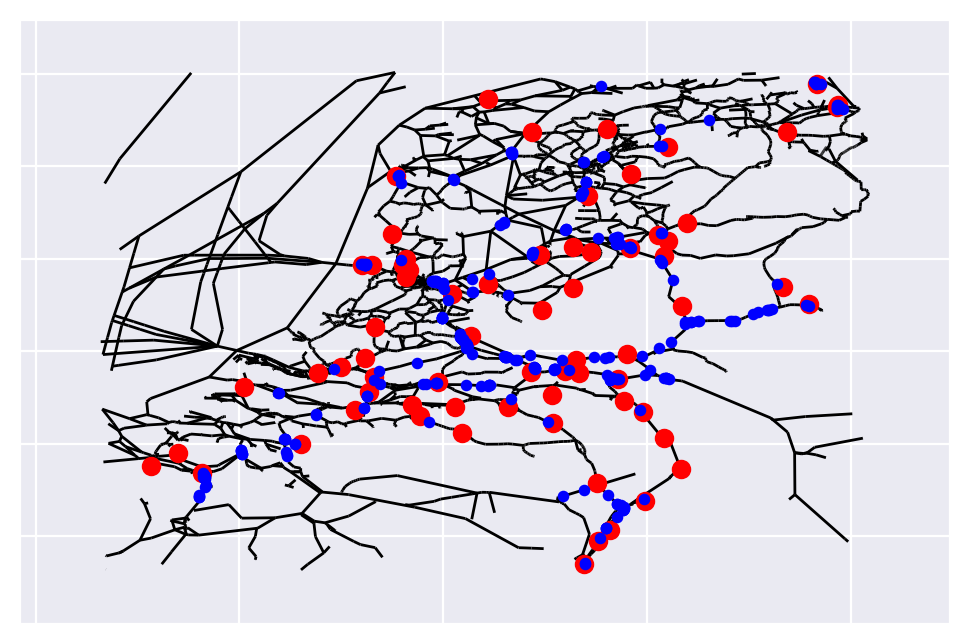

In [17]:
#visual check
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
plt.scatter(df_h.lon,df_h.lat,c='r')
a = df_h.loc[df_h.lon==df_h.lon.min()]
# plt.scatter(a.lon,a.lat,c='b')
berth_nodes = df_nodes.loc[df_nodes.n.str.contains('Berth')].index
berth_nodes = df_nodes.loc[df_nodes.index.isin(berth_nodes)]
plt.scatter(berth_nodes.X,berth_nodes.Y, s=10, c='b')

## Step 2: throw out all small nodes and only keep the largest component

In [18]:
#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [19]:
#check out codes to base selection on
df_links.Code.unique()
nodes_to_keep = list(df_links.loc[df_links.Code != '_0'].source) + list(df_links.loc[df_links.Code != '_0'].target)
G = G.subgraph(nodes_to_keep)
G = nx.Graph(G)

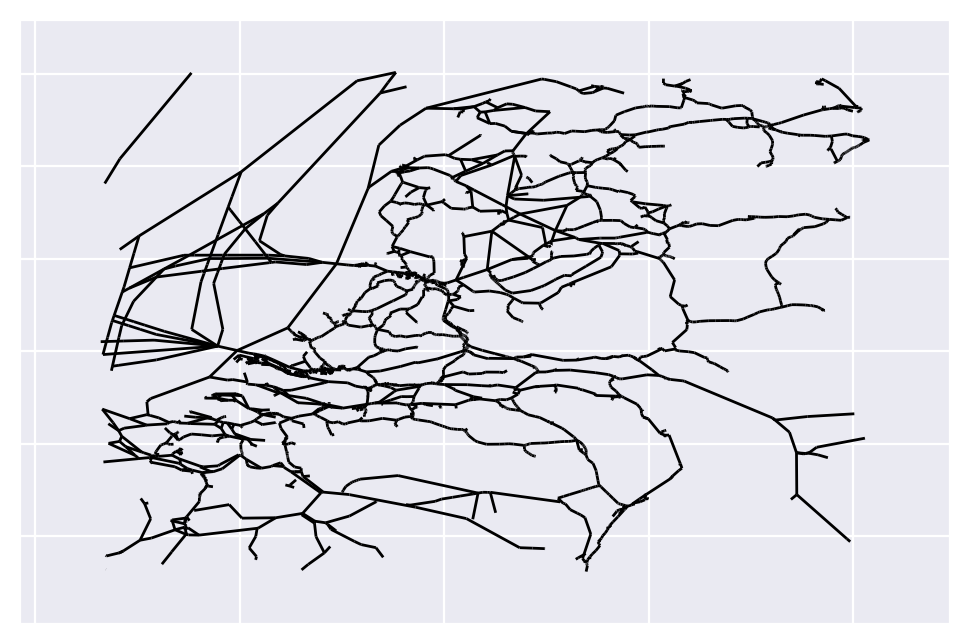

In [20]:
plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)

In [21]:
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

## Step 3: Determine harbour nodes
A harbour node, is a node on the ongoing route along which the harbour is located. This node may be found because of its degree which is higher than 3 and because the link of which it is the source node, has the tag vaarwegvak 0 tot H-0.

In [22]:
#Check initial range: 5k seems to be okay

In [23]:
dev = 0.04
a = 51.985103 + dev
b = 5.898730 + dev

In [24]:
geopy.distance.geodesic((51.985103,5.898730),(a,b))

Distance(5.230073271041756)

In [25]:
# create an additional column to put corresponding harbour node in
df_h['harbour_node'] = 0
# loop over all harbour entries
for i in df_h.index:
    x = df_h.lon[i]
    y = df_h.lat[i]
    dev = 0.04

    #find nodes within deviation
    #select nodes near
    selection = list(df_nodes.loc[(df_nodes.X.between(x-dev, x+dev)) & (df_nodes.Y.between(y-dev, y+dev)) & (df_links.GeoType == 'section')&(df_links.source.str.isdigit())].index)

    # in some areas there are very few nodes, therefore iteratively increase range to look for nodes until at least one is found
    while len(selection) == 0:
        dev+=0.1
        selection = list(df_nodes.loc[(df_nodes.X.between(x-dev, x+dev)) & (df_nodes.Y.between(y-dev, y+dev))].index)

    #select corresponding links and subset links that go to harbour, subset sections with origin is number (no object)
    selection = df_links.loc[((df_links.source.isin(selection))|(df_links.target.isin(selection)))&(df_links.Name == 'Vaarwegvak van 0 tot 0 - H')&(df_links.GeoType == 'section')&(df_links.source.str.isdigit())]

    if len(selection) != 0:
        selection['dist'] = 0
        # if there are items, take nearest, first we need to determine dists
        for j in selection.index:
            sel_source = selection.source[j]
            sel_source = df_nodes.loc[sel_source]
            selection.dist[j]=geopy.distance.geodesic((x,y),(sel_source.X,sel_source.Y))
        # sort by dist and pick firstG
        selection = selection.loc[selection.dist == selection.dist.min()].source
        df_h['harbour_node'][i]= selection.values[0]
    else:
        selection = list(df_nodes.loc[(df_nodes.X.between(x-dev, x+dev)) & (df_nodes.Y.between(y-dev, y+dev))].index)
        if len(selection) != 0:
            selection = df_links.loc[((df_links.source.isin(selection))|(df_links.target.isin(selection)))]
            selection['dist'] = 0
            for j in selection.index:
                sel_source = selection.source[j]
                sel_source = df_nodes.loc[sel_source]
                selection.dist[j]=geopy.distance.geodesic((x,y),(sel_source.X,sel_source.Y))
            # sort by dist and pick firstG
            selection = selection.loc[selection.dist == selection.dist.min()].source
            df_h['harbour_node'][i]= selection.values[0]
        else:
            print('Check entry', df_h.city_full[i])

C:\Users\Fabia\AppData\Local\Temp\ipykernel_16340\3678971257.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection['dist'] = 0
C:\Users\Fabia\AppData\Local\Temp\ipykernel_16340\3678971257.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection.dist[j]=geopy.distance.geodesic((x,y),(sel_source.X,sel_source.Y))
C:\Users\Fabia\AppData\Local\Temp\ipykernel_16340\3678971257.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [26]:
harbour_nodes = list(df_h.harbour_node.unique())

In [27]:
harbour_nodes

['8866686',
 'B41318_A',
 '8866425',
 '8864005',
 '8863360',
 '8866763',
 '8863207',
 '8867083',
 '8868208',
 '8861528',
 '8865600',
 '8868222',
 '8867395',
 '8861568',
 '8867429',
 '8862663',
 '8863518',
 '8867258',
 '8865412',
 '8866297',
 '8863614',
 '8866893',
 '8864018',
 '8863019',
 '8863861',
 '8865756',
 '8862085',
 '8863408',
 '22638320',
 '8864153',
 '8862497',
 '8868191',
 '8863260',
 '8866748',
 '8863709',
 '8863125',
 '8861305',
 '8864954',
 '30984595',
 '8868423',
 '8867538',
 '8864494',
 '22638327',
 '8863818',
 '8862570',
 '8861718',
 '8863152',
 '8863306',
 '8866775',
 '22638156',
 '8868223',
 '8868266',
 '8863469',
 '22638146',
 'B35038_A',
 '8867240',
 '8865990',
 '8866671',
 '22637863',
 '8864111',
 '8866627',
 '8864566',
 '8864837',
 '8863966',
 '8865605',
 '8866889',
 '8862506']

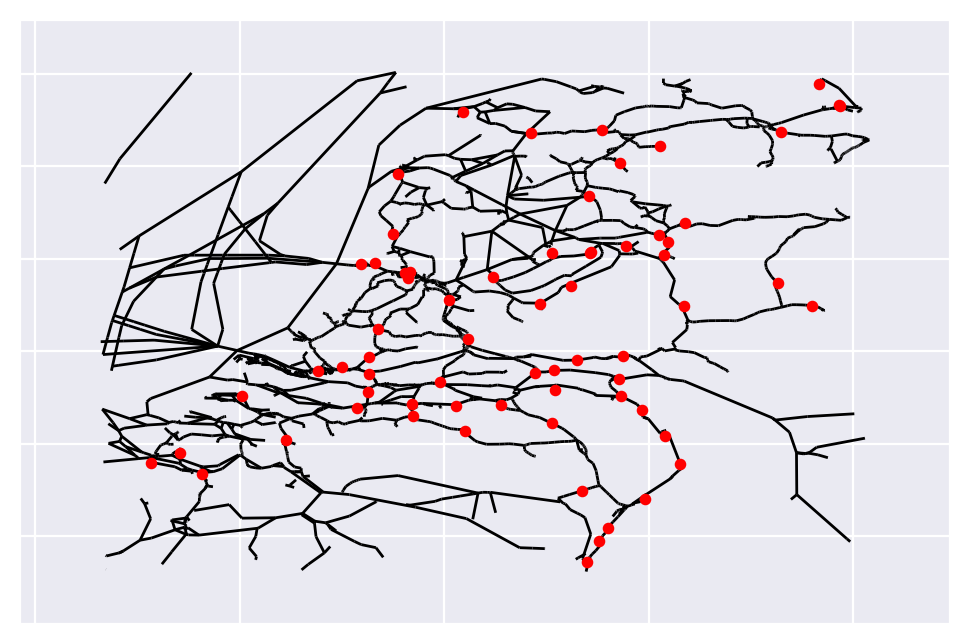

In [28]:
plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, harbour_nodes,node_size=10, node_color='red')

## Step 4: only keep dijkstra paths between nodes
Shortest route may depend upon ship type...
Check this first

In [29]:
node_list = []
for node_1 in harbour_nodes:
    # print(node_1)
    others = harbour_nodes.copy()
    others.remove(node_1)
    # print(others)
    for node_2 in others:
            # determine route from a to b
        try:
            # get path
            path = nx.dijkstra_path(G, node_1, node_2, 'length_m')

            # add nodes to node list
            node_list.append(path)

            #remove duplicates
            node_list = list(set(node_list))

        except:
            print('no path between', node_1, node_2)

no path between 8866686 B41318_A
no path between 8866686 8866425
no path between 8866686 8864005
no path between 8866686 8863360
no path between 8866686 8866763
no path between 8866686 8863207
no path between 8866686 8867083
no path between 8866686 8868208
no path between 8866686 8861528
no path between 8866686 8865600
no path between 8866686 8868222
no path between 8866686 8867395
no path between 8866686 8861568
no path between 8866686 8867429
no path between 8866686 8862663
no path between 8866686 8863518
no path between 8866686 8867258
no path between 8866686 8865412
no path between 8866686 8866297
no path between 8866686 8863614
no path between 8866686 8866893
no path between 8866686 8864018
no path between 8866686 8863019
no path between 8866686 8863861
no path between 8866686 8865756
no path between 8866686 8862085
no path between 8866686 8863408
no path between 8866686 22638320
no path between 8866686 8864153
no path between 8866686 8862497
no path between 8866686 8868191
no pat

In [30]:
expanded_node_list = [x for xs in node_list for x in xs]
node_list = list(set(expanded_node_list))
G = G.subgraph(node_list)
G = nx.Graph(G)

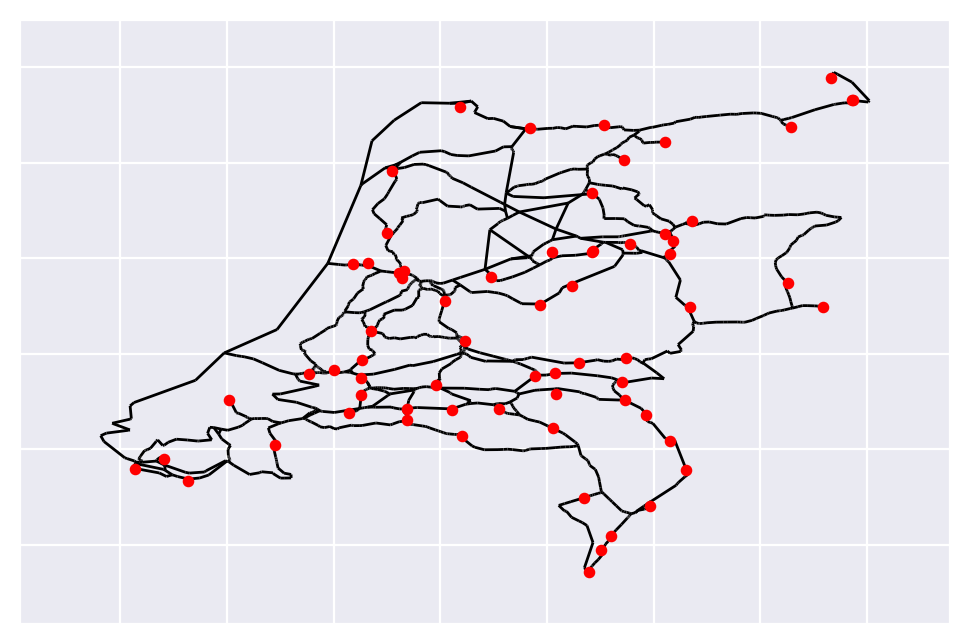

In [31]:
plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, harbour_nodes,node_size=10, node_color='red')

In [32]:
K = G.copy()
#extract data
df_links = nx.to_pandas_edgelist(K)
df_nodes = pd.DataFrame.from_dict(dict(K.nodes(data=True)), orient='index')
#check out codes to base selection on
df_links.Code.unique()

array([nan, 'VI_B', 'II', 'VI_C', 'V_A', 'V_B', 'IV', 'I', 'VI_A', 'III',
       '_0'], dtype=object)

In [33]:
df_links.loc[(df_links.Code == '_0')]

,source,target,PushedDepth,WidePushedLength,WidePushedWidth,geometry,Name,SeaFairingHeight,GeneralWidth,Id_navigability,...,CoupledLength,StartJunctionId,SeaFairingDepth,subgraph,Wkt,PushedLength,WidePushedDepth,Code,GeneralDepth,length
693,35228581,35228490,NaN,NaN,NaN,"{'type': 'LineString', 'coordinates': ((4.2676...",Vaarwegvak van 2 tot 3 - H,NaN,NaN,25902759.0,...,NaN,35228581,NaN,0,"LINESTRING (4.26762838695281 51.3499607288521,...",NaN,NaN,_0,NaN,0.017630
812,8867600,8864167,NaN,NaN,NaN,"{'type': 'LineString', 'coordinates': ((5.4018...",Vaarwegvak van 0 tot 5 - H,NaN,NaN,12830.0,...,NaN,8867600,NaN,0,"LINESTRING (5.40182198703637 53.1773143983601,...",NaN,NaN,_0,NaN,0.076037
903,8866727,8867153,NaN,NaN,NaN,"{'type': 'LineString', 'coordinates': ((4.3880...",Vaarwegvak van 0 tot 1 - H,NaN,NaN,44025.0,...,NaN,8866727,NaN,0,"LINESTRING (4.38801816186906 51.678798010768, ...",NaN,NaN,_0,NaN,0.012520
1047,8864167,30986055,NaN,NaN,NaN,"{'type': 'LineString', 'coordinates': ((5.4018...",Vaarwegvak van 0 tot 0 - H,NaN,NaN,29101.0,...,NaN,8864167,NaN,0,"LINESTRING (5.40182198703637 53.1773143983601,...",NaN,NaN,_0,NaN,0.000621
1148,35228583,35228490,NaN,NaN,NaN,"{'type': 'LineString', 'coordinates': ((4.3007...",Vaarwegvak van 0 tot 2 - H,NaN,NaN,25902759.0,...,NaN,35228583,NaN,0,"LINESTRING (4.30077710921406 51.3499323034941,...",NaN,NaN,_0,NaN,0.033149


In [34]:
# check if other ships are likely to take the same routes
for i in df_links.Code.unique():
    a = df_links.loc[df_links.Code == i]
    print(i, len(a)/len(df_links)*100)

nan 0.0
VI_B 9.601605044425336
II 24.70621954714818
VI_C 6.3341931785611925
V_A 30.180567497850387
V_B 1.4330753797649758
IV 13.270278016623674
I 8.942390369733449
VI_A 1.8343364860991689
III 3.2387503582688453
_0 0.14330753797649756


### Q: how many links for large ships (e.g. not I, II or III) are not in the graph now?
Also plot links for small ships only in other color

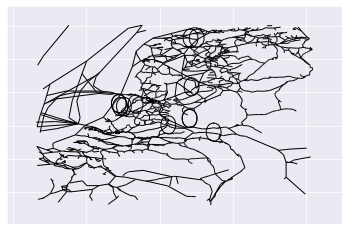

In [122]:
# select nodes from org graph with not _0, I, II or III
K = pickle.load(open('data/network_digital_twin_v0.3.pickle', 'rb'))
df_links_or = nx.to_pandas_edgelist(K)
df_nodes_or = pd.DataFrame.from_dict(dict(K.nodes(data=True)), orient='index')

# bounding box nl
bb = (3.31497114423, 50.803721015, 7.09205325687, 53.5104033474)
df_nodes_or = df_nodes_or.loc[(df_nodes_or.X.between(bb[0], bb[2])) & (df_nodes_or.Y.between(bb[1], bb[3]))]

#subset graph and make editable again
K = K.subgraph(df_nodes_or.index)
K = nx.Graph(K)

df_links_or = nx.to_pandas_edgelist(K)
df_nodes_or = pd.DataFrame.from_dict(dict(K.nodes(data=True)), orient='index')

nx.draw_networkx_edges(K, pos_dict)

In [123]:
a = df_links_or.loc[~df_links_or.Code.isin(['_0','I','II','III'])]

In [124]:
large_edges_full = []
for i in a.index:
    large_edges_full.append(tuple([a.source[i], a.target[i]]))

In [125]:
len(large_edges_full)

3943

In [126]:
large_edges = []
large_links = df_links.loc[~df_links.Code.isin(['_0','I','II','III'])]
for i in large_links.index:
    large_edges.append(tuple([large_links.source[i], large_links.target[i]]))

small_edges = []
small_links = df_links.loc[df_links.Code.isin(['_0','I','II','III'])]
for i in small_links.index:
    small_edges.append(tuple([small_links.source[i], small_links.target[i]]))

for node1, node2 in K.edges:
    if node1 == node2:
        print("Self loop identified node", node1)
        K.remove_edge(node1,node2)

df_links_or = nx.to_pandas_edgelist(K)
df_nodes_or = pd.DataFrame.from_dict(dict(K.nodes(data=True)), orient='index')
large_not_in_G = list(set(large_edges_full)-set(large_edges))

Self loop identified node S46058_A
Self loop identified node S51275_A
Self loop identified node S16237927_A
Self loop identified node S48415_A
Self loop identified node S16240_A
Self loop identified node S24198_A
Self loop identified node S27425_A
Self loop identified node S28525_A
Self loop identified node S28525_B
Self loop identified node S56863_A
Self loop identified node S56863_B
Self loop identified node S57264_A


In [127]:
len(small_edges)

1292

In [128]:
len(large_edges)

2197

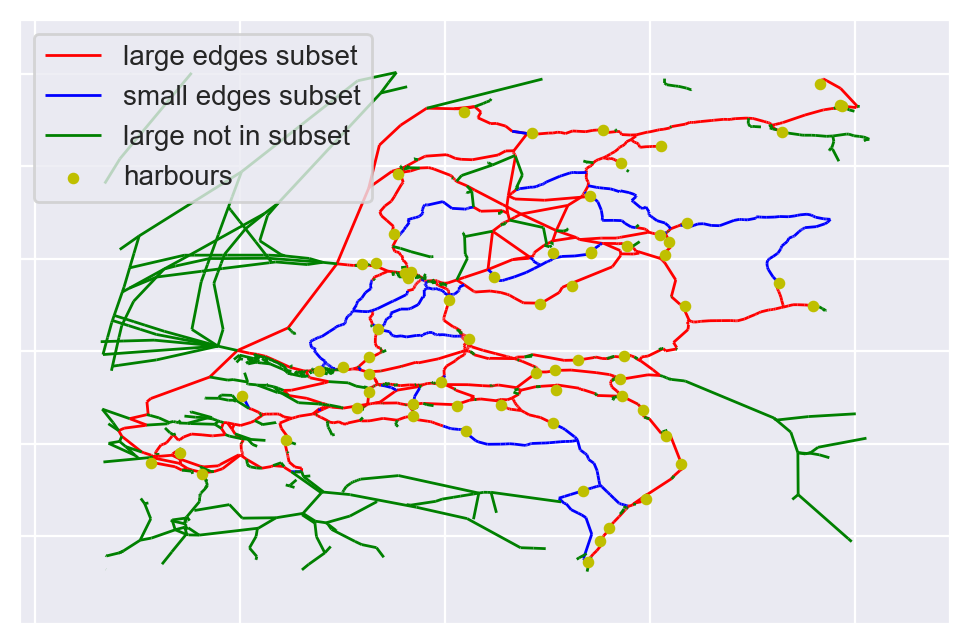

In [132]:
fig, ax = plt.subplots(dpi=200)
K = K.subgraph(large_not_in_G)
K = nx.Graph(K)

nx.draw_networkx_edges(G, pos_dict,large_edges, edge_color='r',ax=ax, label='large edges subset')
nx.draw_networkx_edges(G, pos_dict, small_edges, edge_color='b',ax=ax, label='small edges subset')
nx.draw_networkx_edges(G, pos_dict, large_not_in_G, edge_color='g',ax=ax, label='large not in subset')
nx.draw_networkx_nodes(G, pos_dict, harbour_nodes, node_size=10, node_color='y', label='harbours')
plt.legend()
plt.show()
